In [4]:
%load_ext autoreload
%autoreload 2
%autosave 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from tqdm.notebook import tqdm
import numpy as np
from fastai.text import *
from modules.callbacks import *
from pathlib2 import Path
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from fastai.callbacks import lr_finder, SaveModelCallback, EarlyStoppingCallback,ReduceLROnPlateauCallback
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from modules.model import *

defaults.device = torch.device('cuda')
#CUDA_VISIBLE_DEVICES=""
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 2 seconds


cuda


## Data Preparation

### Download Data (Freanch English Sentence Pairs)

In [10]:
path = Config().data_path()

In [ ]:
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}

--2020-08-04 22:40:41--  https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.250.46
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.250.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598183296 (2.4G) [application/x-tar]
Saving to: ‘/home/santhosh/.fastai/data/giga-fren.tgz.1’

giga-fren.tgz.1       2%[                    ]  59.94M  29.9KB/s    eta 7h 11m 

In [ ]:
# ! tar xf {path}/giga-fren.tgz -C {path} 

In [ ]:
path = Config().data_path()/'giga-fren'
path.ls()

### Load DataSets

In [ ]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')

### Filter Question pairs

We will use regex to pick out questions by finding the strings in the English dataset that start with "Wh" and end with a question mark.

In [ ]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren.release2.fixed.fr'

In [ ]:
lines = ((re_eq.search(eq), re_fq.search(fq)) 
        for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

In [ ]:
qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

In [5]:
## Writing processed data into pickle file

#pickle.dump(qs, open('fr-2-en-data/fr-en-qs.pkl','wb'))
qs = pickle.load(open('fr-2-en-data/fr-en-qs.pkl','rb'))

en_qs,fr_qs = zip(*qs)

In [6]:
path = Path()

In [7]:
en_tok = pickle.load((path/'fr-2-en-data/en_tok.pkl').open('rb'))
fr_tok = pickle.load((path/'fr-2-en-data/fr_tok.pkl').open('rb'))

In [8]:
TMP_PATH = path/'fr-2-en-data/tmp/'

def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy',allow_pickle=True)
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [9]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

## Fastai's Data Bunch

Creating a function that collects batch of x,y pairs fills padding

In [10]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    
    # unpack samples to tuples
    samples = to_data(samples)
    
    # find max len of x, y batch wihich decides inp seq length
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    
    max_len = max(max_len_x,max_len_y)
    
    # create a dummy tensor of height batch_size and width max_len with padded value
    res_x = torch.zeros(len(samples), max_len).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len).long() + pad_idx
    
    # if backwards activate reverse mode used in bi-directional   
    if backwards: pad_first = not pad_first
    
    # fill vocabulary with word indices
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i, :len(s[0])],res_y[i, :len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    
    # flip backward if backwards = True
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
        
    res_x_mask = (res_x != pad_idx).unsqueeze(-2)
    res_y_mask = None
    
    # target mask creation
    if res_y is not None:
        dec_y = res_y[:, :-1]
        tar_y = res_y[:, 1:]
        decode_lengths = torch.tensor([len(s[1]) for s in samples])-1
    return (res_x[:,1:],dec_y,decode_lengths), tar_y

Creates a Text databunch object with 

In [11]:
class Seq2SeqDataBunch(TextDataBunch):
    " decorator adds following method additionally to base class 'TextDataBunch"
    
    ## Class method of Seq2SeqDataBunch (inherited from TextDataBunch) 
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=8, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=device, no_check=True, backwards:bool=False, **dl_kwargs)-> DataBunch:
        
        "Function takes pytorch dataset object transforms into 'databunch' for classification and cls will allow to access parent class methods just  like 'self'"
        
        # store dataset obj into list
        datasets = cls._init_ds(train_ds,valid_ds,test_ds)
        val_bs = ifnone(val_bs, bs) #returns val_bs if none bs
        
        # stores raw seq of unequal len into tensor with padding
        # below function takes batches output from Dataloader returns padded tensor
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        #sampler function: generater takes dataset then sorts and returns sorted indices    
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        
        # train data loader obj with Sortish sampler(sort with some randomness)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        # other dataloaders with pure sorting append into dataloaders list
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key = lengths.__getitem__)
            dataloaders.append(DataLoader(ds,batch_size=val_bs,
                                          sampler = sampler,**dl_kwargs))
        
        return cls(*dataloaders, path = path, device = device, collate_fn=collate_fn, no_check = no_check)

In [12]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.width', 10000)
pd.set_option('display.expand_frame_repr', True)


data = pd.DataFrame(qs, columns=['en', 'fr'])

In [21]:
data.sample(5)[['fr', 'en']].style.set_properties(subset=['fr', 'en'], **{'width': '300px'})

,fr,en
10557,Quelle information devrait être fournie?,What information should be provided?
5641,Qu'est qu'un emploi?,What is a job?
29027,Qu'attendez-vous de la nouvelle structure ?,What are your expectations from the newly established structure?
22777,Quel est le meilleur résultat que vous puissiez obtenir de ce contrat?,What is the best result that can be obtained from this agreement?
13895,Quel contrôle peut-on conserver lorsque les données traverses les frontières?,What control does one have when data crosses the border?


In [29]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [14]:
# lowercase
data['en'] = data['en'].apply(lambda x:x.lower())
data['fr'] = data['fr'].apply(lambda x:x.lower())

### create a Seq2SeqTextList (Fastai's datablock api)

In [15]:
# text list with 'fr' column as label  and split list randomly (0.8) 
src = (Seq2SeqTextList.from_df(data, path = path, cols='fr')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='en',label_cls=TextList))

/home/santhosh/miniconda3/envs/CapGen/lib/python3.6/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [16]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

### Model initialize

In [17]:
from modules.model import *  # BERT
from modules.callbacks import *
from transformer.model import Translation

en_emb = torch.load('models/en_emb.pth')
fr_emb = torch.load('models/fr_emb.pth')

databunch = src.databunch()
databunch.batch_size = 64


#model = make_model(len(fr_stoi), len(en_stoi), N=6, h = 6, d_model=300,src_embedding = None,tar_embedding = None).to(device);
model = Translation(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)


/home/santhosh/miniconda3/envs/CapGen/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
dict(src_vocab_size=len(fr_stoi),
    tgt_vocab_size=len(en_stoi),
    d_model=300, d_ff=2048,
    d_k=64, d_v=64, n_heads=6, 
    n_layers=6, src_pad_index=1,
    tgt_pad_index=1, device=device)

{'src_vocab_size': 22188,
 'tgt_vocab_size': 14236,
 'd_model': 300,
 'd_ff': 2048,
 'd_k': 64,
 'd_v': 64,
 'n_heads': 6,
 'n_layers': 6,
 'src_pad_index': 1,
 'tgt_pad_index': 1,
 'device': device(type='cuda')}

### Fastai - with CrossEntropyLoss

In [18]:
def CrossEntropy_loss(input,targets):
    pred,_,_,_,decode_lengths = input
    x,y = pred.contiguous().view(-1, pred.size(-1)), targets.contiguous().view(-1)
    loss = nn.CrossEntropyLoss().to(device)(F.log_softmax(x, dim=-1), y)
    return  loss #loss(pred.data.long(), targets.data.long())


In [27]:
from modules.callbacks import *
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

#criterion = LabelSmoothing(len(en_itos), 1, 0.1).to(device)

#learn = Learner(dataBunch,arch,loss_func= loss_func,opt_func=opt_fn, metrics=[topK_accuracy,BleuMetric(metadata,vocab)],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallback


# Fatai Learner object
learn_CEL = Learner(databunch,model,loss_func=CrossEntropy_loss,wd=0.1, metrics=[seq2seq_acc, CorpusBLEU(len(en_itos))],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallbacklearn = 

#### Learning rate finder

epoch,train_loss,valid_loss,seq2seq_acc,bleu_metric,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.20E-02


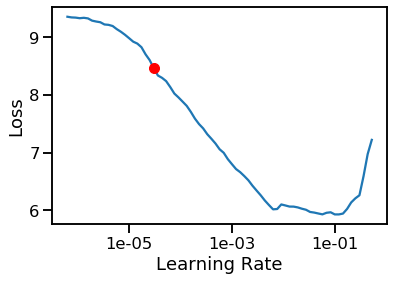

In [19]:
learn_CEL.lr_find()
learn_CEL.recorder.plot(suggestion=True)

#### training epochs

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.456067,2.653436,0.612640,0.433706,01:28
1,2.041358,2.261911,0.642574,0.462979,01:28
2,1.675195,1.926699,0.680742,0.488075,01:28
3,1.384582,1.713956,0.702641,0.511958,01:31
4,1.127888,1.588813,0.723198,0.536749,01:33
5,0.813250,1.529009,0.734520,0.553977,01:37
6,0.497641,1.541128,0.743082,0.570197,01:32
7,0.262595,1.580004,0.747232,0.581183,01:31
8,0.140268,1.620333,0.750187,0.587652,01:31
9,0.086930,1.639049,0.750771,0.589219,01:32


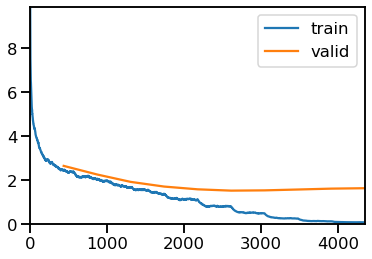

In [28]:
learn_CEL.fit_one_cycle(10, 5e-4, div_factor=5)

In [34]:
%debug

> /home/skumar/miniconda3/envs/ImageCaption/lib/python3.7/site-packages/nltk/translate/bleu_score.py(324)modified_precision()
    322     for reference in references:
    323         reference_counts = (
--> 324             Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
    325         )
    326         for ngram in counts:

ipdb> type(references)
<class 'list'>
ipdb> len(references)
26
ipdb> references
[11, 16, 10, 1954, 17, 41, 19, 10, 49, 662, 27, 3476, 663, 12, 152, 13, 538, 13, 10, 476, 510, 12, 578, 2652, 94, 9]
ipdb> exit


In [18]:
# export model 
learn_CEL.export()

### validation

In [29]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(*xb)[0]
            for x,y,z in zip(xb[0],yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x.cpu()))
                targets.append(learn.data.train_ds.y.reconstruct(y.cpu()))
                outputs.append(learn.data.train_ds.y.reconstruct(z.cpu().argmax(1)))
    return inputs, targets, outputs

In [30]:
inputs, targets, outputs = get_predictions(learn_CEL)

In [31]:
inputs[500],targets[500],outputs[500]

(Text si on parle des gens en xxunk , xxunk que la dynamique de travail et xxunk est différente de celle d’une installation permanente ?,
 Text when it comes to the people on tour , i xxunk that the xxunk dynamic is different from what goes on in a permanent production ?,
 Text whether the comes to the people , xxunk , are and and the work work and different from a a ? a a food resident ?)

In [32]:
inputs[22],targets[22],outputs[22]

(Text quels sont les prix de vente en gros et au détail que vous prévoyez demander pour votre ( vos ) xxunk ) ou produit xxunk contenant notre matériel ?,
 Text what will be your anticipated xxunk and retail price for each of your xxunk ) or any work derived from using our material ?,
 Text what are xxunk the price price and selling about xxunk your of your product and that product material ? from your for product ?)